# Twitter Sentiment Analysis

## Introduction
  
This tutorial explains a method to predict a sentiment of a twitt, in which it will be used RRNs as Deep Learning models. In general, the use of data in Social Networks is being exploited by the industry. For example, the analysis of sentiment of twits can be useful for a company that wants to analyse its new products. However, it is impossible that humans analyse each twit, therefore training deep learning models to predict is a way to scale the analysis.

The data used in this tutorial comes from an investigation made from Stanford’s researchers. They have collected 1.4 millions of twits and classify them as positive or negative emotions based on emoticons written in the same twit, simulating Facebook. The table below contains the emotion category of the emoticon used. The data was downloaded by using the HugginFace API.
  
The structure of the tutorial is divided in three parts, and it will be explained: first, the steps to clean twits in order to have a dataset to do the predictions; second, the description and use of GloVe as a Word Embedding model; third, the use of LSTM in predicting sentiments. The idea of using RRNs is that sequence of words have information that can be used to predict the sentiment.

In [228]:
from datasets import load_dataset
import re
import random
import torch
import torch.nn as nn
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import pandas as pd
import matplotlib.pyplot as plt

## Load Dataset

In [229]:
dataset = load_dataset("sentiment140")

Reusing dataset sentiment140 (/home/nftd/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/9fe1c0ce3319c47cc65ff7e49aac6c34d9c050ab1432988c104b3b275e360f3f)


In [230]:
def read_twitts(data,twitt_n= 10000):
    """Read twitts.

    Parameters
    -----------
    data : DatasetDict
        Dataset loaded from hugginface
    twitt_n : int
        Number of twitts to use. This is to handle the use of memory
    
    Returns
    -----------
    data_train : list
        Train data
    labels_train : list
        Train label
    data_test : list
        Test data
    labels_test : list
        Test label
    """
    set_ = 'train'
    randomlist = random.sample(range(0, 1600000), twitt_n)
    trainrandomlist = random.sample(randomlist,int(len(randomlist)*0.8))
    testrandomlist = []
    for index in randomlist:
        if index not in trainrandomlist:
            testrandomlist.append(index)
    #training set
    data_train, labels_train = [],[]
    for i in trainrandomlist:
        data_train.append(data[set_][i]['text'])
        labels_train.append(data[set_][i]['sentiment'])
    #test set
    data_test, labels_test = [],[]
    for i in testrandomlist:
        data_test.append(data[set_][i]['text'])
        labels_test.append(data[set_][i]['sentiment'])
    return data_train,labels_train,data_test,labels_test

In [231]:
train_data, train_label, test_data, test_label = read_twitts(dataset,16000)

In [232]:
def data_info(data,label, k = 10):
    print('# trainings:', len(data))
    for x, y in zip(label[0:k], data[0:k]):
        print('label:', x, 'review:', y)
    for x, y in zip(label[-k:-1], data[-k:-1]):
        print('label:', x, 'review:', y)

In [233]:
data_info(train_data,train_label)

# trainings: 12800
label: 0 review: @ChristieRessel Serious? I've been going since I was a little girl.  Parents sold our place though. 
label: 4 review: Murray thinks I'm adorkable.  
label: 4 review: @simonwheatley lol! Glad she's back safely 
label: 4 review: Whoever hacked Selena Gomez's Myspace has no life 
label: 4 review: @trvsbrkr Poor girl, the fever is horrible! I hate it! Get well soon Bama! 
label: 0 review: its a wonderful day for working!! 
label: 4 review: @monkofelyon at a conference... good stuff... 
label: 0 review: Ugh now im seriously doubting whether ill be 'unbanned' when it says I will  and I was so looking forward to getting back on then...gah!
label: 4 review: @alandavies1 diggin' your moustachio! Looking good daddio! 
label: 4 review: downloading more hip hop 
label: 4 review: @laurnabee You are thin, you dolt. 
label: 0 review: @aeroform Sounds good... The article is blocked.  I'll have to check it out later.
label: 4 review: raincheck on the hangover... 
lab

## Data cleaning
In this section it will cover a step-by-step guide on how text can be cleaned, the objective is to transform the data into numbers so the models can be trained. It is necessary to understand the twit structure before designing a pipeline, below it is showed an example of a twit which was classified as negative:
  
> @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. 

In [234]:
twit = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it."

The steps to transform the data are the following:
### Remove users
This is a simple step; the objective is to identify words which contains an @ at their left side.

In [235]:
def remove_user(txt):
    return re.sub('@[^\s]+','',txt)
twit = remove_user(twit)
print(twit)

 http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it.


In [236]:
train_data_clean = [remove_user(i) for i in train_data]
test_data_clean = [remove_user(i) for i in test_data]
data_info(train_data_clean,train_label)

# trainings: 12800
label: 0 review:  Serious? I've been going since I was a little girl.  Parents sold our place though. 
label: 4 review: Murray thinks I'm adorkable.  
label: 4 review:  lol! Glad she's back safely 
label: 4 review: Whoever hacked Selena Gomez's Myspace has no life 
label: 4 review:  Poor girl, the fever is horrible! I hate it! Get well soon Bama! 
label: 0 review: its a wonderful day for working!! 
label: 4 review:  at a conference... good stuff... 
label: 0 review: Ugh now im seriously doubting whether ill be 'unbanned' when it says I will  and I was so looking forward to getting back on then...gah!
label: 4 review:  diggin' your moustachio! Looking good daddio! 
label: 4 review: downloading more hip hop 
label: 4 review:  You are thin, you dolt. 
label: 0 review:  Sounds good... The article is blocked.  I'll have to check it out later.
label: 4 review: raincheck on the hangover... 
label: 0 review: Goddd need to get up and shower, hairdressers in less than an hour.

### Remove URL
Although hyperlink can have important information, it will take out from the text.

In [237]:
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
twit = remove_url(twit)
print(twit)

Awww thats a bummer You shoulda got David Carr of Third Day to do it


In [238]:
train_data_clean = [remove_url(i) for i in train_data_clean]
test_data_clean = [remove_url(i) for i in test_data_clean]
data_info(train_data_clean,train_label)

# trainings: 12800
label: 0 review: Serious Ive been going since I was a little girl Parents sold our place though
label: 4 review: Murray thinks Im adorkable
label: 4 review: lol Glad shes back safely
label: 4 review: Whoever hacked Selena Gomezs Myspace has no life
label: 4 review: Poor girl the fever is horrible I hate it Get well soon Bama
label: 0 review: its a wonderful day for working
label: 4 review: at a conference good stuff
label: 0 review: Ugh now im seriously doubting whether ill be unbanned when it says I will and I was so looking forward to getting back on thengah
label: 4 review: diggin your moustachio Looking good daddio
label: 4 review: downloading more hip hop
label: 4 review: You are thin you dolt
label: 0 review: Sounds good The article is blocked Ill have to check it out later
label: 4 review: raincheck on the hangover
label: 0 review: Goddd need to get up and shower hairdressers in less than an hour Just fell back to sleep so now Im even more tired
label: 4 revie

### Tokenize
Tokenize means that the words in the text will be split by a delimiter, normalize by a function and put the words in a list. In our case, it will split the words by spaces and it will transform to undercase all of the words. It will be used the function “get_tokenizer” from torchtext. The result are tokens and an example it is showed below:

In [239]:
tokenizer = get_tokenizer("basic_english")
print(tokenizer(twit))

['awww', 'thats', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it']


In [240]:
train_data_token = [tokenizer(i) for i in train_data_clean]
test_data_token = [tokenizer(i) for i in test_data_clean]
data_info(train_data_token,train_label)

# trainings: 12800
label: 0 review: ['serious', 'ive', 'been', 'going', 'since', 'i', 'was', 'a', 'little', 'girl', 'parents', 'sold', 'our', 'place', 'though']
label: 4 review: ['murray', 'thinks', 'im', 'adorkable']
label: 4 review: ['lol', 'glad', 'shes', 'back', 'safely']
label: 4 review: ['whoever', 'hacked', 'selena', 'gomezs', 'myspace', 'has', 'no', 'life']
label: 4 review: ['poor', 'girl', 'the', 'fever', 'is', 'horrible', 'i', 'hate', 'it', 'get', 'well', 'soon', 'bama']
label: 0 review: ['its', 'a', 'wonderful', 'day', 'for', 'working']
label: 4 review: ['at', 'a', 'conference', 'good', 'stuff']
label: 0 review: ['ugh', 'now', 'im', 'seriously', 'doubting', 'whether', 'ill', 'be', 'unbanned', 'when', 'it', 'says', 'i', 'will', 'and', 'i', 'was', 'so', 'looking', 'forward', 'to', 'getting', 'back', 'on', 'thengah']
label: 4 review: ['diggin', 'your', 'moustachio', 'looking', 'good', 'daddio']
label: 4 review: ['downloading', 'more', 'hip', 'hop']
label: 4 review: ['you', 'are

### Drop empty twits
This step is simple, after the transformations it can be found twits without tokens. Hence, all empty lists will be dropped, within their labels.

In [241]:
def drop_empty_tweets(data, label):
    data_non_empty = []
    label_non_empty = []
    empty_twitt = 0
    for i, tweet in enumerate(data):
        if len(tweet) > 0:
            data_non_empty.append(tweet)
            label_non_empty.append(label[i])
        else:
            empty_twitt += 1
    print(f"There were {empty_twitt} empty twitts")
    return data_non_empty,label_non_empty

In [242]:
train_data_non_empty,train_label_non_empty = drop_empty_tweets(train_data_token,train_label)
test_data_non_empty,test_label_non_empty = drop_empty_tweets(test_data_token,test_label)

There were 22 empty twitts
There were 11 empty twitts


In [243]:
len(train_label_non_empty)

12778

### Convert label
The frequency of each sentiment label is shown below. The label `4` correspond to a positive sentiment, while `0` is a negative sentiment.

In [244]:
pd.Series(train_label_non_empty).value_counts()

4    6391
0    6387
dtype: int64

This means that we are facing with balanced classes, hence there is no need to specify weights in the loss function. However, the Neural Networks is set to predict {0,1}. Therefore, this is easy to solve by changing the label `4` to `1`.

In [245]:
def convert_labels(label):
    label_conv = []
    for i in label:
        if i == 4:
            label_conv.append(1)
        else:
            label_conv.append(0)
    return label_conv

In [246]:
train_label_converted = convert_labels(train_label_non_empty)
test_label_converted = convert_labels(test_label_non_empty)

In [247]:
len(train_label_converted)

12778

### Create vocabulary
A vocabulary is a dictionary of unique tokens. If the tokens are counted, we find that there are tokens which have high frequency in the collection (all twits), and tokens that happens once. Word embeddings can handle both scenarios because it just transforms a word into a vector. The problem is that the size of the vocabulary is big for a single machine, therefore it will stablish a threshold of minimum of 20 in token’s frequency. With this threshold, now the dictionary has around 22 thousand tokens. Although, the tokens which don’t comply with the threshold will not be dropped, they are going to be set as a zero vector in the next section.
  
Also, it is computacional efficient to have a dictionary since it is going to be quicker the word to vector transformation.

In [248]:
def create_vocabulary(data):
    wordfreq = {}
    for twitts in data:
        for token in twitts:
            if token not in wordfreq.keys():
                wordfreq[token] = 1
            else:
                wordfreq[token] += 1
    return wordfreq

In [249]:
vocabulary = create_vocabulary(train_data_token)

Examples of most common tokens:

In [250]:
df_vocab = pd.DataFrame.from_dict(vocabulary, orient='index', columns=['count'])
df_vocab.sort_values('count',ascending=False).head(10)

,count
i,5943
to,4569
the,4156
a,3029
my,2513
and,2429
you,2096
is,1899
it,1814
in,1716


Examples of less common tokens:

In [251]:
df_vocab.sort_values('count').head(10)

,count
reloading,1
thur,1
frinot,1
spooks,1
mutti,1
estou,1
ver,1
todos,1
enorme,1
honoured,1


Now the words that don't comply with the threshold will be dropped from the vocabulary. The dictionary will be used in the following step.

In [252]:
def select_vocabulary(vocab,min_token_freq = 20):
    final_vocabulary = {}
    for i in vocab.keys():
        if vocab[i] > min_token_freq:
            final_vocabulary[i] = vocab[i]
    return final_vocabulary

In [253]:
vocabulary = select_vocabulary(create_vocabulary(train_data_non_empty))

### Padding to same twitt length
This is the final step before converting the tokens to vectors. The point of this step is that RRNs needs to define a specific sequence length. This means that it cannot be trained from data which twits have different number of tokes. In order to solve this problem, same as CNN, it is necessary to “pad” the tweets if the length is lesser to a threshold. If the tweet has lesser tokens, then it fills the token "<PAD\>" at the beginning until the threshold is reached. Finally, if a tweet has more tokens than the threshold, then the sequence will be “cut” in the threshold number.
  
- The maximum number of tokens found in a twit is 40
- The threshold selected is 30 (based on the figure below)



Text(0, 0.5, 'freq')

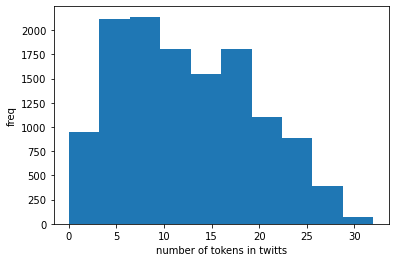

In [254]:
lenght = [len(i) for i in train_data_token]
plt.hist(lenght)
plt.xlabel("number of tokens in twitts")
plt.ylabel("freq")

In [255]:
def padding_same_length(data,lenght = 30):
    data_copy = data.copy()
    data_lenght = []
    for tweet in data_copy:
        if len(tweet) < lenght:
            i = len(tweet)
            while i < lenght:
                tweet.insert(0,'<pad>')
                i += 1
        elif len(tweet) > lenght:
            tweet = tweet[0:lenght]
        data_lenght.append(tweet)
    return data_lenght

In [256]:
train_data_lenght = padding_same_length(train_data_non_empty,30)
test_data_lenght = padding_same_length(test_data_non_empty,30)

In [257]:
len(train_data_lenght)

12778

## GloVe and Batching
This section will cover the use of Glove and Batching.
### Glove
The objective of using Glove in this problem is to reduce the dimensionality of words. The classic solution is to convert the words into one-hot encoding representation. But this method has two problems: first, the dimensionality of the vector is going to be 20 thousand, which is large; second, there is no possibility to relate two closest words. GloVe solves these two problems by representing a word as a vector. This vector has a low dimension and it can be used to compare words by using, for example, cosine similarity.
  
In this tutorial we are going to use a pretrained word-vector called “Twitter.27B” which was trained by using 2B of tweets, 27B tokens and 1.2M in vocabulary size. It will be used 25 dimensions in the vector.

In [258]:
embedding = GloVe(name='twitter.27B', dim = 25)

In [259]:
embedding['the']

tensor([-1.0167e-02,  2.0194e-02,  2.1473e-01,  1.7289e-01, -4.3659e-01,
        -1.4687e-01,  1.8429e+00, -1.5753e-01,  1.8187e-01, -3.1782e-01,
         6.8390e-02,  5.1776e-01, -6.3371e+00,  4.8066e-01,  1.3777e-01,
        -4.8568e-01,  3.9000e-01, -1.9506e-03, -1.0218e-01,  2.1262e-01,
        -8.6146e-01,  1.7263e-01,  1.8783e-01, -8.4250e-01, -3.1208e-01])

Also, the word “<pad\>” will have a zero vector representation:

In [260]:
embedding['<pad>']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])

Now, we can convert the tokens into a vector representation. The implementation will be that the vector will be saved in a dictionary based on the “trimmed” dictionary, so the token can be query faster.

In [261]:
embedding_vocabulary = {}
for i in vocabulary.keys():
    embedding_vocabulary[i] = embedding[i]

def convert_token_to_vector(data,vocab):
    X_train_emb = []
    for twitts in data:
        twitt_emb = []
        for token in twitts:
            if token in vocab:
                twitt_emb.append(vocab[token])
            else:
                twitt_emb.append(torch.zeros(25))
        X_train_emb.append(twitt_emb)
    return X_train_emb

X_train = convert_token_to_vector(train_data_lenght,embedding_vocabulary)
X_test = convert_token_to_vector(test_data_lenght,embedding_vocabulary)
y_train = train_label_converted
y_test = test_label_converted

In [262]:
len(train_label_converted)

12778

Finally, the embedding dataset will be dropped to free memory.

In [263]:
%reset_selective -f embedding

### Create Batch
With the data represented by vectors, we are almost set to train the models. But first we need to create a DataLoader in which the model can be use the data through batches. This implementation uses torch.utils.data.Dataset API, in which the requirement is that the data must have two methods: first, it needs to calculate the number of elements in the training/test set; second, it needs a method which can return data from an index.

In [264]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, set, labels):
        'Initialization'
        self.labels = labels
        self.set = set

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'

        X = self.set[index]
        X = torch.stack(X)
        y = self.labels[index]

        return X, y

I am using torch.stack to convert the lists into tensors. Finally, a DataLoader can be built by using the above class.

In [265]:
df_train = Dataset(X_train,y_train)
df_test = Dataset(X_test,y_test)

In [266]:
len(y_train)

12778

In [267]:
len(X_train)

12778

## Deep Learning
This chapter is divided in explaining LSTM architecture and the implementation of the model.
### LSTM
It stands for Long Short-Term Memory and it is classified as a Recurrent Neural Network (RRN). Ordinary RRNs are tools which deal with sequence data, and this property makes it very attractive in classifying sentiments. One of the sequence model’s problem is not having the ability to remember long term memory, by losing impacts of very early events in the sequence. In the opposite, LSTMs are sequence models which solve this problem, they are capable to retain important data in its memory and it can preserve it in the long term. Hence, this type of model can have either long and short term memory.
  
Compared with ordinary RRNs, LSTMs have two inputs and outputs:
- Memory cell: contains the data to be saved or removed during the time.
- Hidden state: contains the parameters of the RNN.

There are three gates to either add or remove data from the memory cell. Each gate is built by a Neural Network (NN), a sigmoid function and a multiplier factor. The three gates are:
- Forget gate: Allows deletion of data from the memory cell.
- Update gate with candidate memory: Allows addition of new data into the memory cell.
- Output gate: Allows to update the parameters in the hidden state.

In [291]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Hyper-parameters
input_size = 25
sequence_lenght = 30
hidden_size = 500
num_classes = 2
num_epochs = 200
batch_size = 200
learning_rate = 0.001
num_layers = 3

train_loader = torch.utils.data.DataLoader(df_train,batch_size=batch_size,shuffle=True,drop_last = True)
test_loader = torch.utils.data.DataLoader(df_test,batch_size=batch_size,shuffle=True,drop_last = True)

In [292]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_state,num_layers,num_classes):
        super(LSTM,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers, batch_first = True)
        # x -> batchsize, sequence, input_size
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 30, 25), h0: (2, n, 128)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 30, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 2)
        return out

In [293]:
model = LSTM(input_size,hidden_size,num_layers,num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [294]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (twitts, labels) in enumerate(train_loader):  
        # size: [N, 30, 25]
        twitts = twitts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(twitts)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        
        loss.backward()
        optimizer.step()

    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for twitts, labels in test_loader:
            twitts = twitts.to(device)
            labels = labels.to(device)
            outputs = model(twitts)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the test twitts: {acc} %')

Epoch [1/200], Loss: 0.6176
Accuracy of the network on the test twitts: 65.1 %
Epoch [2/200], Loss: 0.5898
Accuracy of the network on the test twitts: 66.33333333333333 %
Epoch [3/200], Loss: 0.6673
Accuracy of the network on the test twitts: 67.26666666666667 %
Epoch [4/200], Loss: 0.6021
Accuracy of the network on the test twitts: 67.86666666666666 %
Epoch [5/200], Loss: 0.6303
Accuracy of the network on the test twitts: 65.53333333333333 %
Epoch [6/200], Loss: 0.5812
Accuracy of the network on the test twitts: 67.6 %
Epoch [7/200], Loss: 0.5174
Accuracy of the network on the test twitts: 68.83333333333333 %
Epoch [8/200], Loss: 0.5387
Accuracy of the network on the test twitts: 69.23333333333333 %
Epoch [9/200], Loss: 0.5101
Accuracy of the network on the test twitts: 68.86666666666666 %
Epoch [10/200], Loss: 0.5181
Accuracy of the network on the test twitts: 70.06666666666666 %
Epoch [11/200], Loss: 0.6009
Accuracy of the network on the test twitts: 70.26666666666667 %
Epoch [12/20

KeyboardInterrupt: 

In [280]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for twitts, labels in test_loader:
        twitts = twitts.to(device)
        labels = labels.to(device)
        outputs = model(twitts)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test twitts: {acc} %')

Accuracy of the network on the test twitts: 67.8 %
